In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import timedelta

import torch
from chronos import ChronosPipeline
import transformers

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Load Model

In [3]:
seed=2012
transformers.set_seed(seed=seed)

In [4]:
# load base model and tokenizer
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cuda",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

Some weights of T5ForConditionalGeneration were not initialized from the model checkpoint at amazon/chronos-t5-small and are newly initialized: ['decoder.embed_tokens.weight', 'encoder.embed_tokens.weight', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Load Data

In [5]:
dataset = pd.read_csv('https://raw.githubusercontent.com/anishsaha12/chronos-time-series-forecast/main/sample_data.csv')
dataset.columns = ['date']+[i for i in range(32)]

In [6]:
dataset.head(n=3)

,date,0,1,2,3,4,5,6,7,8,...,22,23,24,25,26,27,28,29,30,31
0,0,0.000000,1.039855,0.000000,0.435170,0.000000,0.710575,0.954063,0.124169,0.847184,...,0.947294,0.239174,0.650565,0.276929,0.046912,0.936842,0.000000,0.981829,0.610598,0.947558
1,1,0.000000,1.050124,0.000945,0.549761,0.084528,0.720295,0.928997,0.105205,0.946126,...,1.046078,0.190809,0.700803,0.283263,0.000000,1.054262,0.030550,0.917890,0.507722,0.986225
2,2,0.091398,1.022995,0.052936,0.610019,0.085238,0.744780,0.914587,0.117345,0.896372,...,0.957098,0.265690,0.680801,0.224716,0.000000,1.016217,0.043501,0.918779,0.600669,1.032316


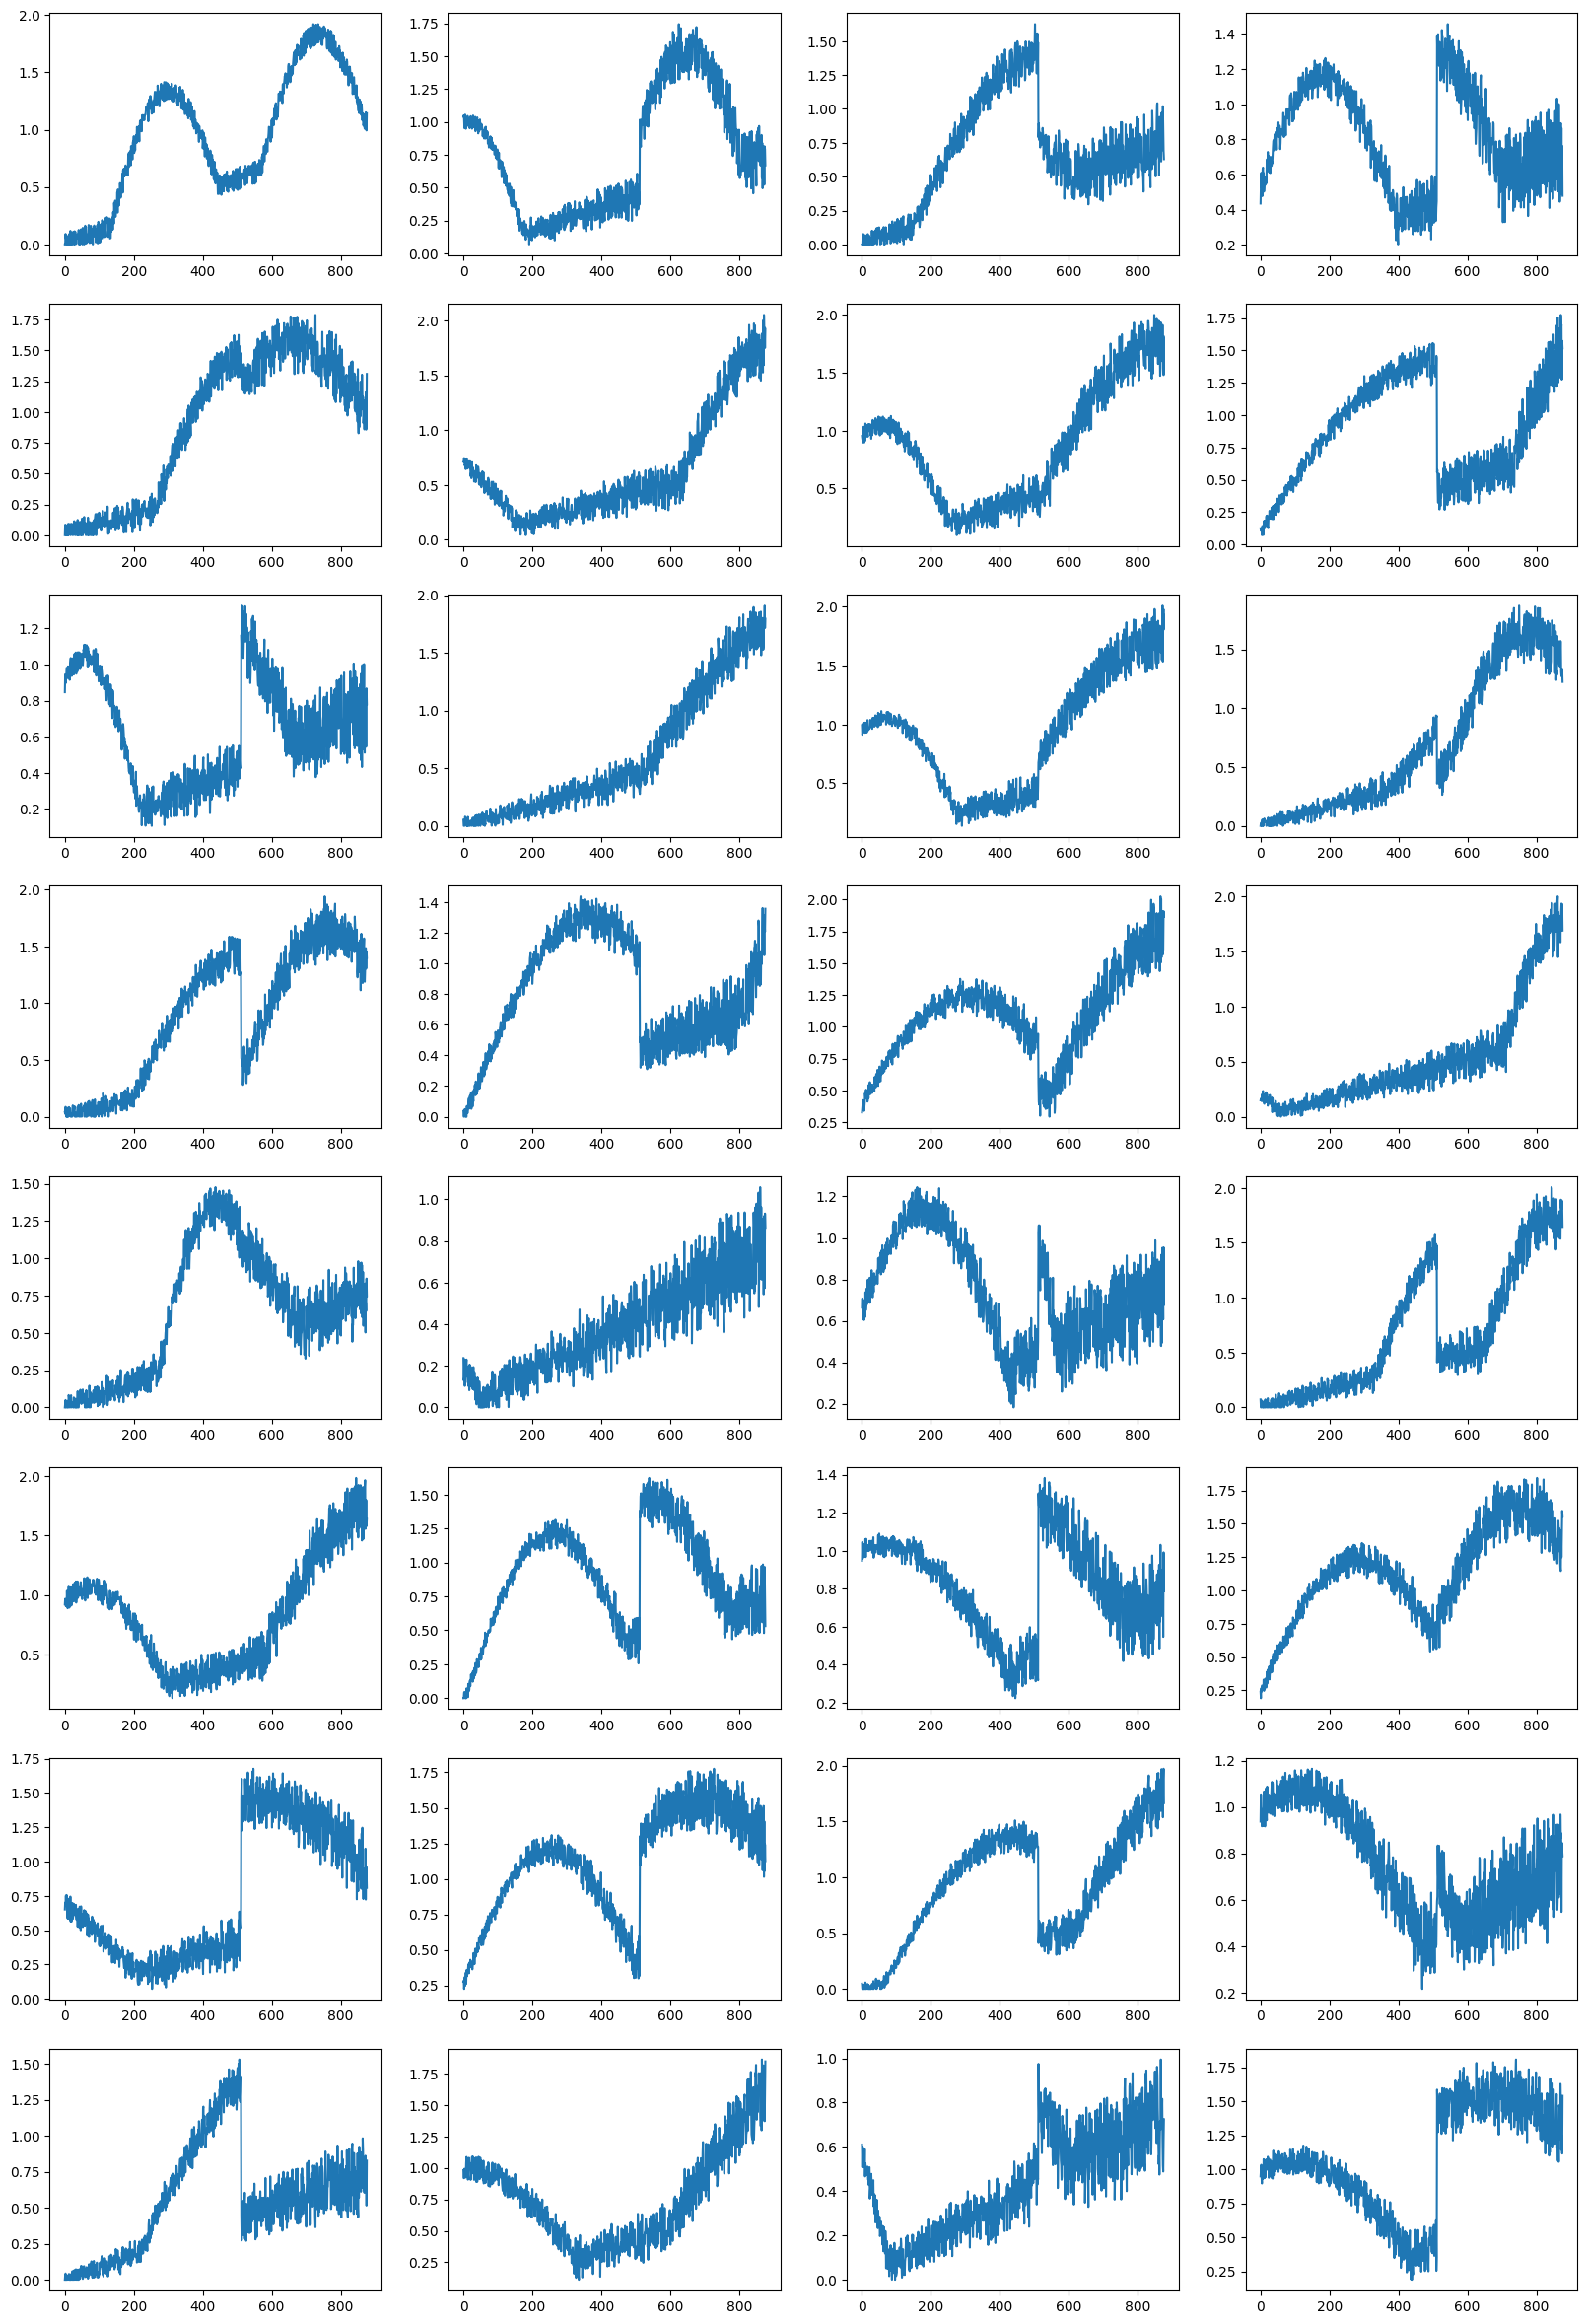

In [7]:
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 30))  # define the figure and subplots
axes = axes.ravel()
for i in range(32):
    axes[i].plot(dataset[i])

## Generate Predictions

In [8]:
def generate_predicitons(dataset, batch_size):
    all_unique_ids = dataset.drop(columns=['date']).columns.to_list()
    batch_unique_ids = [all_unique_ids[i:(i+batch_size)] for i in range(0,len(all_unique_ids),batch_size)]
    print('Num Batches:',len(batch_unique_ids))

    val_data = []
    for b,batch_ids in enumerate(batch_unique_ids):
        if (b%10)==0:
            print('Processing Batch:',b)

        time_series_batch_df = dataset[['date']+batch_ids]

        train_end = 511 ## 512 values
        val_prd = [512, 876] ## 365 values

        data_df = time_series_batch_df[
            time_series_batch_df['date']<=train_end
        ].drop(columns=['date']).T.values

        ground_truth = time_series_batch_df[
            (time_series_batch_df['date']>=val_prd[0])&
            (time_series_batch_df['date']<=val_prd[1])
        ]
        ground_truth = ground_truth.set_index('date').unstack().reset_index()
        ground_truth.columns = ['unique_id','date','true']

        context = torch.tensor(data_df)

        prediction_length = 365
        with torch.no_grad():
            transformers.set_seed(seed=seed)
            forecast = pipeline.predict(
                context,
                prediction_length,
                num_samples=20,
                temperature=1.0,
                top_k=200,
                top_p=1.0,
                limit_prediction_length=False
            )
            low, median, high = np.quantile(forecast.numpy(), [0.1, 0.5, 0.9], axis=1)
        del forecast
        torch.cuda.empty_cache()

        val_frcst_data = pd.DataFrame(median.T)
        val_frcst_data.insert(0, "date", range(val_prd[0], val_prd[1]+1))
        val_frcst_data.columns = time_series_batch_df.columns
        val_frcst_data = val_frcst_data.set_index('date').unstack().reset_index()
        val_frcst_data.columns = ['unique_id','date','forecast_med']

        val_frcst_low_data = pd.DataFrame(low.T)
        val_frcst_low_data.insert(0, "date", range(val_prd[0], val_prd[1]+1))
        val_frcst_low_data.columns = time_series_batch_df.columns
        val_frcst_low_data = val_frcst_low_data.set_index('date').unstack().reset_index()
        val_frcst_low_data.columns = ['unique_id','date','forecast_low']

        val_frcst_high_data = pd.DataFrame(high.T)
        val_frcst_high_data.insert(0, "date", range(val_prd[0], val_prd[1]+1))
        val_frcst_high_data.columns = time_series_batch_df.columns
        val_frcst_high_data = val_frcst_high_data.set_index('date').unstack().reset_index()
        val_frcst_high_data.columns = ['unique_id','date','forecast_high']

        val_frcst_data = val_frcst_low_data.merge(val_frcst_data).merge(val_frcst_high_data)

        val_frcst_data = ground_truth.merge(val_frcst_data, on=['unique_id','date'])
        val_data.append(val_frcst_data)

    return pd.concat(val_data)

In [9]:
def PE(a, f):
    a = np.array(a)
    f = np.array(f)
    indices = (a>=1)
    if len(a[indices])>0:
        return np.abs(np.sum(a[indices]) - np.sum(f[indices])) / np.sum(a[indices])
    else:
        return 0

In [10]:
val_data_8 = generate_predicitons(dataset=dataset, batch_size=8)

Num Batches: 4
Processing Batch: 0


In [11]:
val_data_32 = generate_predicitons(dataset=dataset, batch_size=32)

Num Batches: 1
Processing Batch: 0


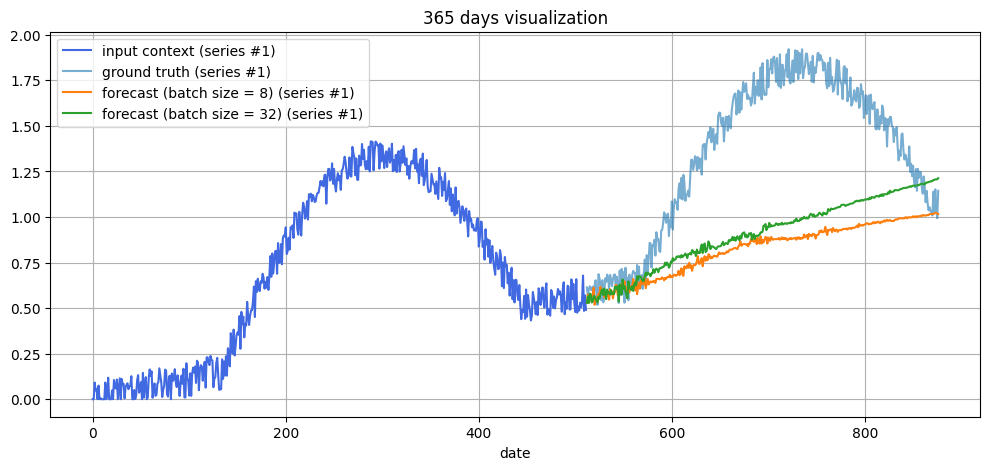

In [12]:
fig,ax = plt.subplots(figsize=(12, 5))
dataset[
    (dataset['date']<512)
].set_index('date')[0].plot(
    label='input context (series #1)',
    color="royalblue",
    ax=ax
)
dataset[
    (dataset['date']>=512)
].set_index('date')[0].plot(
    label='ground truth (series #1)',
    alpha=0.6,
    ax=ax
)
val_data_8[
    (val_data_8.unique_id==0)
].set_index('date')['forecast_med'].plot(
    label='forecast (batch size = '+str(8)+') (series #1)',
    ax=ax
)
val_data_32[
    (val_data_32.unique_id==0)
].set_index('date')['forecast_med'].plot(
    label='forecast (batch size = '+str(32)+') (series #1)',
    ax=ax
)
plt.legend()
plt.title('365 days visualization')
plt.grid()
plt.show()

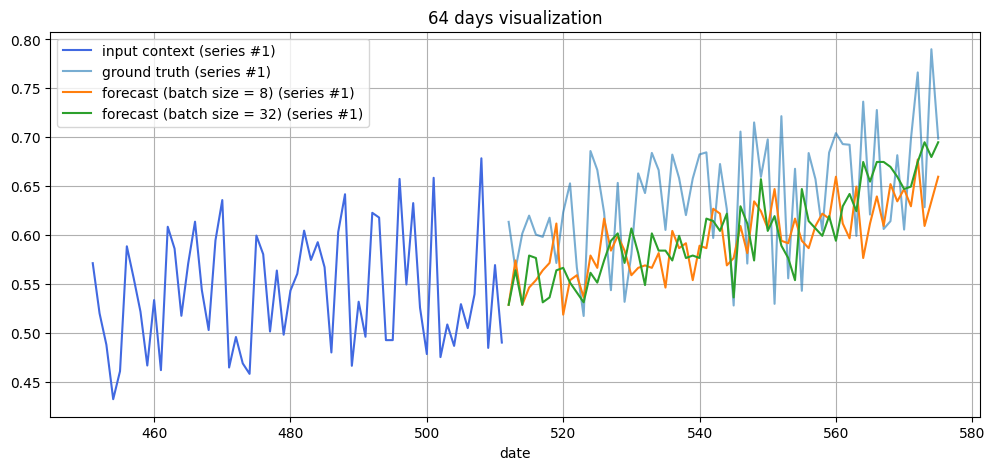

In [13]:
fig,ax = plt.subplots(figsize=(12, 5))
dataset[
    (dataset['date']>450)&
    (dataset['date']<512)
].set_index('date')[0].plot(
    label='input context (series #1)',
    color="royalblue",
    ax=ax
)
dataset[
    (dataset['date']>=512)&
    (dataset['date']<576)
].set_index('date')[0].plot(
    label='ground truth (series #1)',
    alpha=0.6,
    ax=ax
)
val_data_8[
    (val_data_8.unique_id==0)&
    (val_data_8['date']<576)
].set_index('date')['forecast_med'].plot(
    label='forecast (batch size = '+str(8)+') (series #1)',
    ax=ax
)
val_data_32[
    (val_data_32.unique_id==0)&
    (val_data_32['date']<576)
].set_index('date')['forecast_med'].plot(
    label='forecast (batch size = '+str(32)+') (series #1)',
    ax=ax
)
plt.legend()
plt.title('64 days visualization')
plt.grid()
plt.show()

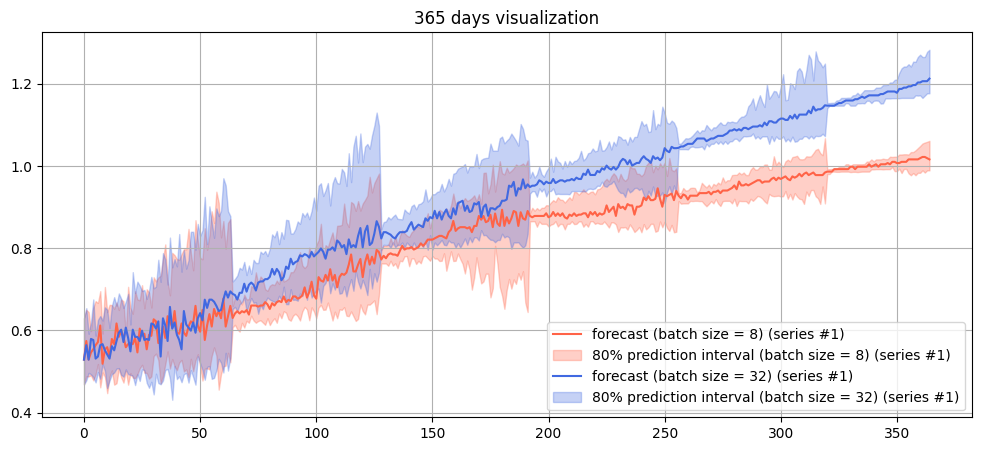

In [14]:
fig,ax = plt.subplots(figsize=(12, 5))
ax.plot(
    val_data_8[val_data_8.unique_id==0]['forecast_med'],
    label='forecast (batch size = '+str(8)+') (series #1)',
    color="tomato"
)
ax.fill_between(
    range(365), 
    val_data_8[val_data_8.unique_id==0]['forecast_low'], val_data_8[val_data_8.unique_id==0]['forecast_high'], 
    color="tomato", 
    alpha=0.3, label="80% prediction interval (batch size = "+str(8)+") (series #1)"
)

ax.plot(
    val_data_32[val_data_32.unique_id==0]['forecast_med'],
    label='forecast (batch size = '+str(32)+') (series #1)',
    color="royalblue"
)
ax.fill_between(
    range(365), 
    val_data_32[val_data_32.unique_id==0]['forecast_low'], val_data_32[val_data_32.unique_id==0]['forecast_high'], 
    color="royalblue", 
    alpha=0.3, label="80% prediction interval (batch size = "+str(32)+") (series #1)"
)

plt.legend(loc="lower right")
plt.title('365 days visualization')
plt.grid()
plt.show()

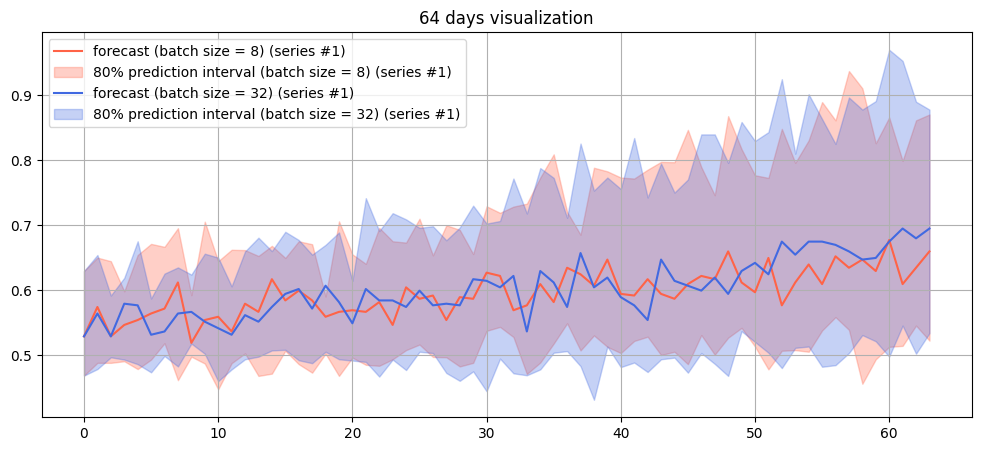

In [15]:
fig,ax = plt.subplots(figsize=(12, 5))
ax.plot(
    val_data_8[(val_data_8.unique_id==0)&(val_data_8['date']<576)]['forecast_med'],
    label='forecast (batch size = '+str(8)+') (series #1)',
    color="tomato"
)
ax.fill_between(
    range(64), 
    val_data_8[(val_data_8.unique_id==0)&(val_data_8['date']<576)]['forecast_low'], 
    val_data_8[(val_data_8.unique_id==0)&(val_data_8['date']<576)]['forecast_high'], 
    color="tomato", 
    alpha=0.3, label="80% prediction interval (batch size = "+str(8)+") (series #1)"
)

ax.plot(
    val_data_32[(val_data_32.unique_id==0)&(val_data_32['date']<576)]['forecast_med'],
    label='forecast (batch size = '+str(32)+') (series #1)',
    color="royalblue"
)
ax.fill_between(
    range(64), 
    val_data_32[(val_data_32.unique_id==0)&(val_data_32['date']<576)]['forecast_low'], 
    val_data_32[(val_data_32.unique_id==0)&(val_data_32['date']<576)]['forecast_high'], 
    color="royalblue", 
    alpha=0.3, label="80% prediction interval (batch size = "+str(32)+") (series #1)"
)

plt.legend(loc="upper left")
plt.title('64 days visualization')
plt.grid()
plt.show()

In [16]:
val_PE_8 = val_data_8.groupby([
    'unique_id'
]).apply(
    lambda grp: PE(grp['true'],grp['forecast_med'])
).reset_index().rename(columns={0:'PE_8'})

val_PE_32 = val_data_32.groupby([
    'unique_id'
]).apply(
    lambda grp: PE(grp['true'],grp['forecast_med'])
).reset_index().rename(columns={0:'PE_32'})
val_PE = pd.merge(val_PE_8,val_PE_32)

In [17]:
val_PE

,unique_id,PE_8,PE_32
0,0,0.425713,0.358578
1,1,0.670619,0.522725
2,2,0.828296,0.656877
3,3,0.639813,0.622042
4,4,0.127238,0.008510
5,5,0.601556,0.618293
6,6,0.757225,0.785058
7,7,0.445066,0.260414
8,8,0.630530,0.639425
9,9,0.700075,0.717341
